# Sensitivity Analysis of a Real-World Model

Notebook developed by Saman Razavi and Kasra Keshavarz

### For the VARS method, please cite:

Razavi, S., & Gupta, H. V. (2016). A new framework for comprehensive, robust, and efficient global sensitivity analysis: 1. Theory. Water Resources Research, 52(1), 423-439. https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015WR017558

Razavi, S., & Gupta, H. V. (2016). A new framework for comprehensive, robust, and efficient global sensitivity analysis: 2. Application. Water Resources Research, 52(1), 440-455. https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2015WR017559


### For HBV-SASK, please cite:

Razavi, S., Sheikholeslami, R., Gupta, H. V., & Haghnegahdar, A. (2019). VARS-TOOL: A toolbox for comprehensive, efficient, and robust sensitivity and uncertainty analysis. Environmental modelling & software, 112, 95-107. https://www.sciencedirect.com/science/article/pii/S1364815218304766

## Exercise 2: Sensitivity Analysis of HBV-SASK
### Objective:

This notebook runs sensitivity analysis on the HBV-SASK model using the STAR-VARS method and returns VARS sensitivity indices such as total-variogram effects (i.e., IVARS-50), Sobol total-order effects, and Morris elementary effects.

First import the needed librares, including `VARS` for sensitivity analysis and the `Model` class for creating a wrapper around the desired model so that it can be inputted into VARS.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from varstool import VARS, Model
import hbv

### Introduce the model

Define the function of interest in sensitivity analysis. Here, the following function runs the HBV-SASK model and returns a **single model response**. The model response here could be a flux or state variable at a given time step or a goodness-of-fit performance metric. 

In [2]:
def custom_HBV_SASK_1(x):
    param = x.to_dict()
    # running the HBV-SASK Model
    basin = 'Oldman Basin'  # choose the basin of interest, either 'Oldman Basin' or 'Banff Basin'
    flux, state, forcing = hbv.HBV_SASK(basin, param)

    # choose the model response of interest, two options here: (1) direct model response or (2) performance metric
    
    # (1) for direct model response at a given time step, use the following
    start_day = end_day = '2005-10-05' # choose the date of interest
    out = flux['Q_cms'][start_day:end_day]
    
    # (2) for a performance metric over a given historical period, use the following
#     start_day   ='1982-01-01'  # start date of the period over which the performance metric is computed
#     end_day     ='1996-12-31'  # end date of the period over which the performance metric is computed
#     # loading observed streamflow for comparison
#     Qobs        = hbv.obs_streamflow(basin)
#     mean_obs    = np.mean(Qobs[start_day:end_day])
#     denominator = np.mean((Qobs[start_day:end_day] - np.mean(Qobs[start_day:end_day]))**2)
#     numerator   = np.mean((Qobs[start_day:end_day].values.T - flux['Q_cms'][start_day:end_day].values)**2)
#     nse         = 1 - numerator/denominator
#     out         = nse.values[0]
    
    return out

Wrap the function of interest with the `Model` class.

In [3]:
HBV_model = Model(custom_HBV_SASK_1)

Let's run the wrapped function for an arbitrary input and check the model response.

In [4]:
x=pd.Series({#name  #value
             'TT'   : 0.0 ,
             'C0'   : 1.0 ,
             'ETF'  : 0.1 ,
             'LP'   : 0.3 ,
             'FC'   : 250 ,
             'beta' : 2.0 ,
             'FRAC' : 0.7 ,
             'K1'   : 0.05,
             'alpha': 1.5 ,
             'K2'   : 0.01,
             'UBAS' : 1.0 ,
             'PM'   : 1.0 ,
             })
HBV_model(x)

2005-10-05    16.315388
Name: Q_cms, dtype: float64

### Set up a VARS experiment

Create a VARS experiment and set its attributes, according to the table below.
***

<p><center>Table 1. The attributes of the STAR-VARS algorithm </center></p>

| Attribute      | Description |
| :-------------:|:----------- |
|`paramaters`    | The name of every paramter along with its upper and lower bounds           |
|`num_stars`     | The total number of stars centers for VARS analysis                        |
|`delta_h`       | The sampling resolution of the STAR-VARS sampling to generate star points  |
|`ivars_scales`  | The scales of interest for IVARS estimation, e.g, 0.1 and 0.5 correspond (0-0.1) and (0-0.5) <br /> note: can not have a scale larger than 0.5|
|`star_centres`  | User-generated star centers - only used when a sampler is not chosen       |
|`sampler`       | The sampling strategy: `rnd`, `lhs`, `plhs`, `sobol_seq`, or `halton_seq` for generation of star centers|
|`seed`          | The seed number for randomization of the sampling strategy specified by `sampler`, <br /> only needed if a sampler was chosen  |
|`model`         | The wrapper of your model in the `Model` class|
|`bootstrap_flag`| This is a `True`/`False` value to turn on/off bootstrapping of VARS results   |
|`bootstrap_size`| The number of sampling iterations with replacement via bootstrapping |
|`bootstrap_ci`  | The level of confidence used in bootstrap reporting         |
|`grouping_flag` | This is a `True`/`False` value to turn on/off grouping of VARS results   |
|`num_grps`      | The number of groups you want to split your model paramaters into, <br /> if left blank the optimal number of groups will be calculated by VARS|
|`report_verbose`| this is a `True`/`False` value that if `True` will display a loading bar <br /> to show the progession of the VARS analysis, else there will be no progression loading bar|


In [5]:
experiment_1 = VARS(parameters= {  # name   lower bound   upper bound
                                    'TT'   :  [ -4.00   ,   4.00],
                                    'C0'   :  [  0.00   ,   10.0],
                                    'ETF'  :  [  0.00   ,   1.00],
                                    'LP'   :  [  0.00   ,   1.00],
                                    'FC'   :  [  50.0   ,   500 ],
                                    'beta' :  [  1.00   ,   3.00],
                                    'FRAC' :  [  0.10   ,   0.90],
                                    'K1'   :  [  0.05   ,   1.00],
                                    'alpha':  [  1.00   ,   3.00],
                                    'K2'   :  [  0.00   ,   0.05],
                                    'UBAS' :  [  1.00   ,   3.00],
                                    'PM'   :  [  0.50   ,   2.00],},
                    num_stars      = 10,
                    delta_h        = 0.1,
                    ivars_scales   = (0.1, 0.3, 0.5),
                    sampler        = 'lhs',
                    seed           = 123456789,
                    model          = HBV_model,
                    bootstrap_flag = True,
                    bootstrap_size = 100,
                    bootstrap_ci   = 0.9,
                    grouping_flag  = True,
                    num_grps       = 3,
                    report_verbose = True,
                   )

### Run STAR-VARS

Now, run the VARS experiment set up above.

In [6]:
experiment_1.run_online()

model evaluation:   0%|                                                                       | 0/1090 [00:00<…

building pairs:   0%|                                                                          | 0/120 [00:00<…

VARS analysis:   0%|                                                                            | 0/10 [00:00<…

factor ranking:   0%|                                                                            | 0/2 [00:00<…

bootstrapping and grouping:   0%|                                                              | 0/100 [00:00<…

### Check out the results

When the VARS analysis is completed, let's check out the results of sensitivity analysis.

**IVARS: Integrated variogram Across a Range of Scales** 

IVARS indices are the primary sensitivity indices by the VARS approach. First, print all the IVARS indices for the scale ranges of interest.

In [7]:
cols = experiment_1.parameters.keys()
experiment_1.ivars[cols]

,TT,C0,ETF,LP,FC,beta,FRAC,K1,alpha,K2,UBAS,PM
0.1,3.120639,0.128285,0.070703,0.061202,0.242770,0.011007,0.185011,0.037823,0.035762,0.140108,0.073140,1.311210
0.3,34.947451,0.931527,1.092383,1.173057,3.631158,0.191582,3.511810,0.513419,0.495386,1.012486,1.320420,25.516826
0.5,102.239926,1.940225,4.260390,5.148026,13.143351,0.810007,15.777662,1.609106,1.682997,2.249208,5.159518,115.221003


 Choose a scale range and plot the respective IVARS indices. Two points:
 
    POINT1: VARS-50 (h=[0-0.5]), called ***Total-Variogram Effect*** is the most comprehensive sensitivity index.
    POINT2: Plotting sensitivity results in log scale helps us better differentiate less influential parameters.

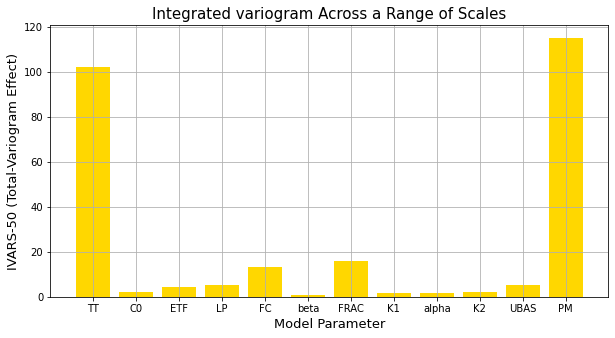

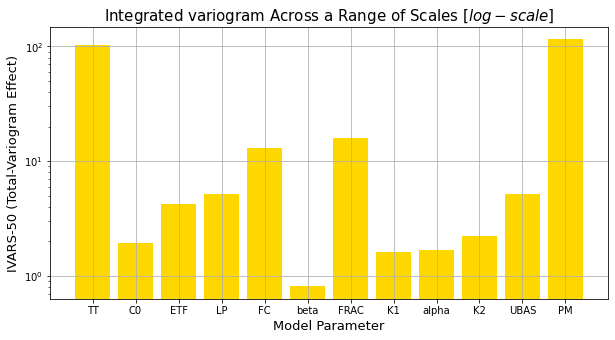

In [8]:
ivars_scale = 0.5 # Choose the scale range of interest, e.g., 0.1, 0.3, or 0.5

cols = experiment_1.parameters.keys()                     
fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_1.ivars.loc[pd.IndexSlice[ ivars_scale ]][cols], color='gold')
plt.gca().set_title (r'Integrated variogram Across a Range of Scales', fontsize = 15)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('linear')

fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_1.ivars.loc[pd.IndexSlice[ ivars_scale ]][cols], color='gold')
plt.gca().set_title (r'Integrated variogram Across a Range of Scales $[log-scale]$', fontsize = 15)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('log')

**VARS-TO: Sobol Total-Order Effect** 

In addition to the IVARS indices, VARS estimates Sobol variance-based total-order effects as side products. Below, print them and plot them.

In [9]:
cols = experiment_1.parameters.keys()
experiment_1.st.to_frame().T[cols]

param,TT,C0,ETF,LP,FC,beta,FRAC,K1,alpha,K2,UBAS,PM
0,0.601879,0.00779,0.027179,0.036165,0.080194,0.005697,0.11481,0.009031,0.008753,0.009662,0.029884,0.839502


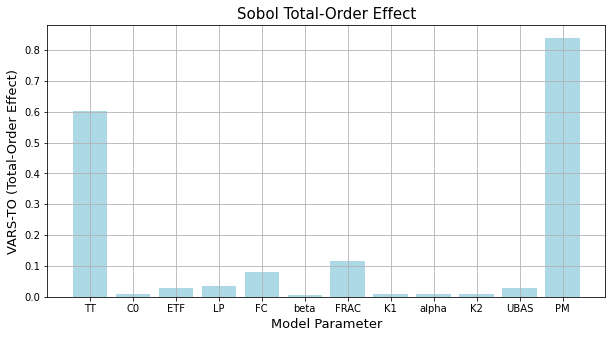

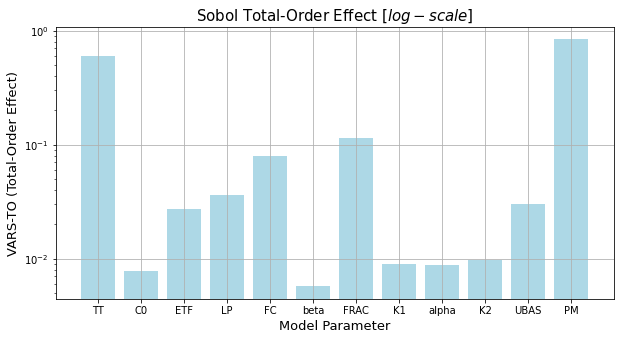

In [10]:
cols = experiment_1.parameters.keys()                     
fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_1.st.to_frame().T.iloc[0][cols], color='lightblue')
plt.gca().set_title (r'Sobol Total-Order Effect', fontsize = 15)
plt.gca().set_ylabel(r'VARS-TO (Total-Order Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('linear')

fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_1.st.to_frame().T.iloc[0][cols], color='lightblue')
plt.gca().set_title (r'Sobol Total-Order Effect $[log-scale]$', fontsize = 15)
plt.gca().set_ylabel(r'VARS-TO (Total-Order Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('log')

**VARS-ABE & VARS-ACE: Morris Elementary Effects** 

In addition to the IVARS and Sobol indices, VARS estimates various versions of Morris derivative-based elementary effects as side products, **mean ABsolute Elementary effect (ABE)** and **mean ACtual elementary effect (ACE)**.

    POINT: In the derivative-based approach, the user needs to choose a delta (step size) for numerical estimation of derivatives. Recommended is to go with the smallest delta available here, which is equal to delta_h, but the user could choose any integer product of delta_h as well.

 Below, print VARS-ABE & VARS-ACE and then plot them.

In [11]:
delta_of_interest = experiment_1.maee.to_frame().unstack(level=0).index.min() # This lines chooses the smallest delta
# delta_of_interest = 0.2  # This line can be used to set other values for delta

# VARS-ABE
experiment_1.maee.to_frame().unstack(level=0).loc[delta_of_interest].to_frame().T

0                                                            \
param        TT        C0      ETF        LP       FC      beta      FRAC   
0.1    3.798995  0.569805  1.29563  1.207406  1.68277  0.520432  2.046945   

                                                        
param       K1     alpha        K2      UBAS        PM  
0.1    0.59633  0.556456  0.988224  0.823897  6.171096

In [12]:
# VARS-ACE
experiment_1.mee.to_frame().unstack(level=0).loc[delta_of_interest].to_frame().T

0                                                           \
param        TT        C0     ETF        LP        FC     beta      FRAC   
0.1   -3.473108 -0.123611 -0.6847  1.207406 -1.594605 -0.38178 -0.973644   

                                                         
param        K1     alpha        K2      UBAS        PM  
0.1   -0.025569 -0.177922  0.511674  0.594385  6.171096

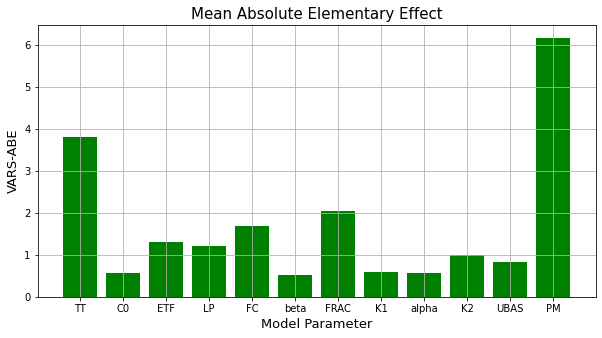

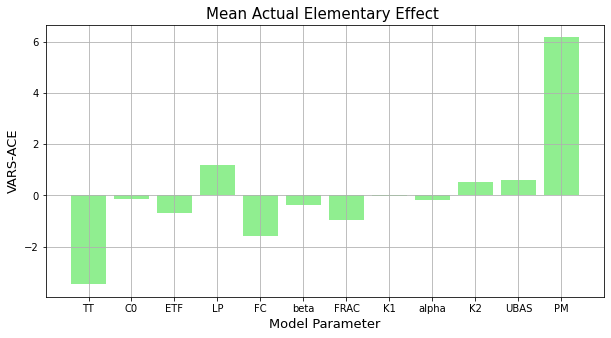

In [13]:
cols = experiment_1.parameters.keys()                     
fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_1.maee.to_frame().unstack(level=0).loc[delta_of_interest].to_frame().T.iloc[0], color='green')
plt.gca().set_title (r'Mean Absolute Elementary Effect', fontsize = 15)
plt.gca().set_ylabel(r'VARS-ABE', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('linear')

fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols, experiment_1.mee.to_frame().unstack(level=0).loc[delta_of_interest].to_frame().T.iloc[0], color='lightgreen')
plt.gca().set_title (r'Mean Actual Elementary Effect ', fontsize = 15)
plt.gca().set_ylabel(r'VARS-ACE', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().grid()
plt.gca().set_yscale('linear')

**Directional Variograms - γ(h)** 

For advanced users of VARS, directional variograms may provide a wealth of information about the structure of the model response surface.

    POINT: Variograms are most meaningful when h (perturbation scale) is between zero and 0.5 of the parameter ranges, but the user can investigate the entire perturbation range (0 – 1).
    
 Below, print the directional variograms and then plot them.

In [14]:
cols = experiment_1.parameters.keys()                     
variograms = experiment_1.gamma.unstack(0)[cols].copy()
variograms

param,TT,C0,ETF,LP,FC,beta,FRAC,K1,alpha,K2,UBAS,PM
h,,,,,,,,,,,,
0.1,62.412771,2.565697,1.414067,1.224031,4.855397,0.220136,3.700219,0.756465,0.715235,2.802153,1.462794,26.224208
0.2,153.219984,4.564776,4.790489,4.948954,16.105449,0.818314,14.752916,2.324952,2.141273,4.634671,5.717308,106.812949
0.3,267.683506,4.369586,9.438555,11.115165,30.701476,1.754742,33.329928,4.105547,4.194697,5.376072,12.048199,244.262199
0.4,336.887934,4.984516,15.558856,19.446106,47.169594,3.012002,59.679131,5.400040,6.252943,6.091664,19.322516,436.157603
0.5,404.390130,5.835343,22.803864,29.492006,65.203195,4.589755,92.628861,7.008114,7.051652,7.175029,26.088723,677.506133
0.6,518.689475,7.148255,30.020486,40.892129,85.919738,6.516059,131.697930,9.018170,7.357259,8.769892,31.448169,963.789110
0.7,688.119569,9.326249,34.966553,53.549838,111.113240,8.828810,174.695689,11.642874,7.937904,10.995235,36.138661,1284.268854
0.8,708.481595,12.813373,35.105873,66.954803,142.353467,11.592609,222.074971,14.949396,8.168658,14.441464,40.672378,1627.489282
0.9,705.287924,23.907977,31.405150,80.331030,177.520688,14.976442,274.238111,18.936929,8.054185,24.592728,44.779202,1994.175448


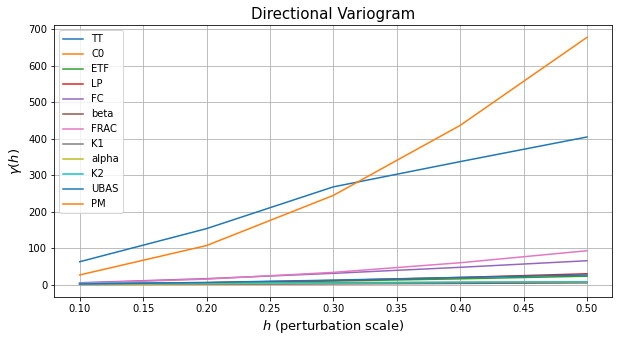

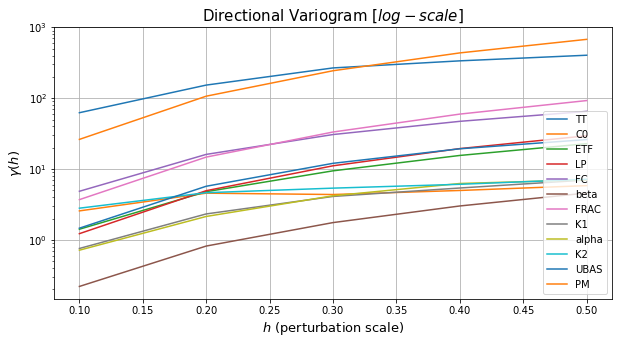

In [15]:
plotting_scale = 0.5 # any number between delta_h and one.

matrix_y = variograms.loc[variograms.index <= plotting_scale].to_numpy()
column_x = variograms.loc[variograms.index <= plotting_scale].index.to_numpy()
matrix_x = np.tile(column_x, (matrix_y.shape[1], 1)).T

fig_cdf = plt.figure(figsize=(10,5))
plt.gca().plot(matrix_x, matrix_y )
plt.gca().set_title (r'Directional Variogram', fontsize = 15)
plt.gca().set_ylabel(r'$γ(h)$', fontsize = 13)
plt.gca().set_xlabel(r'$h$ (perturbation scale)', fontsize=13)
plt.gca().set_yscale('linear')
plt.gca().legend (cols, loc='upper left', fontsize = 10)
plt.gca().grid()

fig_cdf = plt.figure(figsize=(10,5))
plt.gca().plot(matrix_x, matrix_y )
plt.gca().set_title (r'Directional Variogram $[log-scale]$', fontsize = 15)
plt.gca().set_ylabel(r'$γ(h)$', fontsize = 13)
plt.gca().set_xlabel(r'$h$ (perturbation scale)', fontsize=13)
plt.gca().set_yscale('log')
plt.gca().legend (cols, loc='lower right', fontsize = 10)
plt.gca().grid()

All done!